In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import sys
#import joblib

%matplotlib inline

In [29]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_12e741af29a643a68eeee4f49ad31af9 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='622CPFreQbyGCtN5lttf4ixDt5SySIIr2ITsTjAl6LPd',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_12e741af29a643a68eeee4f49ad31af9.get_object(Bucket='ibmwellbeingsurveyinnovationjam-donotdelete-pr-ovhtnaldrwxaxz',Key='Sample_Survey_Data_V 2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head(10)


,RespondentUniqueID,Gender,Age Group,Nationality,BaseCountry,Profession,Marital Status,Dependents,ChronicDisease,Medication,...,EM1,EM2,EM3,EM4,EM5,PHY1,PHY2,PHY3,PHY4,PHY5
0,IBM00001,F,3,EGP,3,1,1,1,0,0,...,4,5,4,5,4,4,4,5,4,5
1,IBM00002,F,4,EGP,4,2,1,1,0,0,...,5,4,5,4,5,4,5,4,5,4
2,IBM00003,F,3,LEB,3,1,1,1,0,0,...,4,4,4,5,4,4,4,5,4,5
3,IBM00004,F,4,EGP,4,2,1,1,0,0,...,4,5,4,5,4,5,4,4,4,5
4,IBM00005,F,4,UAE,4,3,1,1,0,0,...,5,4,5,4,5,4,5,4,4,4
5,IBM00006,F,3,IND,4,4,1,1,0,0,...,4,4,5,4,4,5,4,4,5,4
6,IBM00007,F,4,TUR,3,1,1,1,0,0,...,4,4,5,4,5,5,4,5,4,5
7,IBM00008,F,4,UAE,4,2,1,1,0,0,...,5,5,5,4,4,4,5,4,4,5
8,IBM00009,F,4,UAE,3,3,1,1,0,0,...,4,4,4,4,5,4,5,4,4,4
9,IBM00010,F,3,UAE,4,4,1,1,0,0,...,4,4,4,5,4,5,4,5,4,4


In [7]:
df=df_data_2

In [8]:
# Plot function for feature distribution
def plot_chart(df, col_name, col_type=None):
    
    if col_type == None:
        if is_string_dtype(df[col_name]):
            col_type = 'string'
        elif is_numeric_dtype(df[col_name]):
            col_type = 'numeric'
        else:
            print('Pass col_type to function to specify if it is string or numeric')
        
    if col_type == 'string':
        ax = df[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel('Count')
    elif col_type == 'numeric':
        # if there are less than 10 values in the numeric column we redefine it as a string so we plot a bar chart
        if df[col_name].nunique() <= 10:
            ax = df[col_name].value_counts().sort_index().plot(kind='bar')
        else:
            ax = df[col_name].plot.density()
            
        ax.get_xaxis().set_major_formatter(
            plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    else:
        print(' Re-run specifying the col_type')

    ax.set_xlabel(col_name)
    ax.set_title(col_name + ' Column Distribution')

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)



In [9]:
def plot_categorical_vars(cat_var_for_plotting, prepped_data_pre_transform):
    df_temp = prepped_data_pre_transform.groupby(['CLUSTERS', cat_var_for_plotting]).size().reset_index()
    df_temp.rename(columns={0:'VALUES'}, inplace=True)
    df_temp = df_temp.pivot(index='CLUSTERS', columns=cat_var_for_plotting, values='VALUES').reset_index()
    df_temp
    
    ax = df_temp.set_index('CLUSTERS').plot(kind='bar', stacked=True, figsize=(12,7), title=cat_var_for_plotting + ' by Cluster')
    
    return

In [10]:
def plot_numeric_vars(var, prepped_data_pre_transform, num_clusters):
    
    
    if len(prepped_data_pre_transform[var].unique()) > 2:
    
        plt.figure(figsize=(12,7))
        for cluster in range(0, num_clusters + 1):
            # Subset to the airline
            subset = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS'] == cluster]
            try:
                # Draw the density plot
                sns.distplot(subset[var], hist = False, kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'cluster ' + str(cluster))

                plt.title('Density Plot for ' + var)    
            except:
                pass
    return

## User Inputs and Data Prep

### User Inputs
**customerID :**  This is the customerID which uniquely idenifies each customer<br>
**gender :**  <br>


The user can use the default inputs as listed above or can choose their own. 


### Data Prep
See scripts/customer_segmentation_prep.py for details of data preparation.

The script generates the dataset that is used for clustering. We take a wide form dataset with customer details, filter to include only columns that are relevant, complete data cleaning and produce a dataframe suitable for clustering. 


In [11]:
df.shape

(82, 25)

In [12]:
df.describe()

,Age Group,BaseCountry,Profession,Marital Status,Dependents,ChronicDisease,Medication,PRF1,PRF2,PRF3,...,EM1,EM2,EM3,EM4,EM5,PHY1,PHY2,PHY3,PHY4,PHY5
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.0,82.0,82.000000,82.000000,82.000000,...,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,2.548780,3.109756,1.902439,0.585366,0.707317,0.0,0.0,3.609756,3.707317,3.634146,...,2.951220,3.024390,3.000000,3.048780,2.865854,3.524390,3.585366,3.560976,3.536585,3.573171
std,1.101654,1.054164,1.357283,0.495691,0.457794,0.0,0.0,1.293441,1.383213,1.252279,...,1.506385,1.555362,1.482407,1.506385,1.537693,1.371902,1.387343,1.343457,1.407170,1.352003
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.250000,1.000000,0.000000,0.000000,0.0,0.0,4.000000,4.000000,4.000000,...,1.250000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,1.000000,1.000000,1.000000,0.0,0.0,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,4.000000,4.000000,3.000000,1.000000,1.000000,0.0,0.0,4.000000,5.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.750000,4.750000
max,4.000000,5.000000,5.000000,1.000000,1.000000,0.0,0.0,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [30]:
df.dtypes

Gender            object
Age Group          int64
Nationality       object
BaseCountry        int64
Profession         int64
Marital Status     int64
Dependents         int64
ChronicDisease     int64
Medication         int64
PRF1               int64
PRF2               int64
PRF3               int64
PRF4               int64
PRF5               int64
EM1                int64
EM2                int64
EM3                int64
EM4                int64
EM5                int64
PHY1               int64
PHY2               int64
PHY3               int64
PHY4               int64
PHY5               int64
dtype: object

In [10]:
df.isnull().sum()

RespondentUniqueID    0
Gender                0
Age Group             0
Nationality           0
BaseCountry           0
Profession            0
Marital Status        0
Dependents            0
ChronicDisease        0
Medication            0
PRF1                  0
PRF2                  0
PRF3                  0
PRF4                  0
PRF5                  0
EM1                   0
EM2                   0
EM3                   0
EM4                   0
EM5                   0
PHY1                  0
PHY2                  0
PHY3                  0
PHY4                  0
PHY5                  0
dtype: int64

In [11]:
#df = df.dropna(subset=['MonthlyCharges', 'TotalCharges'], inplace=True)
# Drop the rows where at least one element is missing.
df = df.dropna()

In [14]:
nan_percent = df.isnull().sum()/len(df)
nan_count = df.isnull().sum()
missing=pd.concat([nan_percent, nan_count], axis=1)
missing.columns = ['% Missing', 'Number missing']
missing.sort_values('% Missing',ascending=False)

,% Missing,Number missing
RespondentUniqueID,0.0,0
PRF4,0.0,0
PHY4,0.0,0
PHY3,0.0,0
PHY2,0.0,0
PHY1,0.0,0
EM5,0.0,0
EM4,0.0,0
EM3,0.0,0
EM2,0.0,0


In [15]:
# Preview prepped data
#df_prepped.head()
df_prepped = df #origional df stays intact
df_prepped.isnull().sum()

RespondentUniqueID    0
Gender                0
Age Group             0
Nationality           0
BaseCountry           0
Profession            0
Marital Status        0
Dependents            0
ChronicDisease        0
Medication            0
PRF1                  0
PRF2                  0
PRF3                  0
PRF4                  0
PRF5                  0
EM1                   0
EM2                   0
EM3                   0
EM4                   0
EM5                   0
PHY1                  0
PHY2                  0
PHY3                  0
PHY4                  0
PHY5                  0
dtype: int64

Now that the data is prepared we need to continue with a few more data preparation steps before we can do clustering. First is to simply remove the columns `CustomerID` since that is not needed for segmentation.

In [16]:
# Drop columns not needed for segmentation
df_prepped.drop(['RespondentUniqueID'], axis=1, inplace=True)

In [17]:
df_prepped.head(5)

,Gender,Age Group,Nationality,BaseCountry,Profession,Marital Status,Dependents,ChronicDisease,Medication,PRF1,...,EM1,EM2,EM3,EM4,EM5,PHY1,PHY2,PHY3,PHY4,PHY5
0,F,3,EGP,3,1,1,1,0,0,1,...,4,5,4,5,4,4,4,5,4,5
1,F,4,EGP,4,2,1,1,0,0,2,...,5,4,5,4,5,4,5,4,5,4
2,F,3,LEB,3,1,1,1,0,0,2,...,4,4,4,5,4,4,4,5,4,5
3,F,4,EGP,4,2,1,1,0,0,2,...,4,5,4,5,4,5,4,4,4,5
4,F,4,UAE,4,3,1,1,0,0,2,...,5,4,5,4,5,4,5,4,4,4


### Dummy Variables

Next, since our data contains mixed data types, categorical and numeric, we need to convert those categorical features to numeric by creating binary dummy variables. Once we create the dummy variables from the categorical features we'll drop the original categorical features.

In [36]:
# Create lists of the numeric and categorical features
numeric_cols = list(df_prepped.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prepped.select_dtypes(include=[object]).columns)

# Copy of the prepped dataframe before any transformations are carried out
prepped_data_pre = df_prepped.copy()

# Create dummy variables for categorical features and drop original
for col in categorical_cols:
    df_prepped = pd.concat([df_prepped, pd.get_dummies(df_prepped[col], prefix=col, drop_first=True)], axis=1)
    df_prepped.drop(col, axis=1, inplace=True)

### Standardize Numerical Columns-we skip this step since our numeric variables are standardized

The last step for our data preparation is to standardize the numeric variables. Standardizing numeric values prior to clustering is common practice especially when dealing with features of varying scales (number of children vs summary of assets amount). This helps to improve the cluster quality as well as cluster algorithm accuracy and performance.

In [34]:
# Calculate mean and standard deviation for standardization
numeric_cols_to_exclude_from_clustering = []
dict_col_means = {}
dict_col_stds = {}
for col in numeric_cols:
    col_mean = df_prepped[col].mean()
    col_std = df_prepped[col].std()
    dict_col_means[col] = col_mean
    dict_col_stds[col] = col_std
    numeric_cols_to_exclude_from_clustering.append(col)
    
    df_prepped[col + '_std'] = (df_prepped[col] - col_mean)/col_std

# store the means and standard deviations in one dictionary
dict_standardise = {'mean':dict_col_means, 'std':dict_col_stds}

# drop the numeric columns from clustering data set
df_prepped.drop(numeric_cols_to_exclude_from_clustering, axis=1, inplace=True)

In [19]:
# Preview prepped data with atandardized numeric values
df_prepped.head(5)

,Age Group,BaseCountry,Profession,Marital Status,Dependents,ChronicDisease,Medication,PRF1,PRF2,PRF3,...,PHY4,PHY5,Gender_M,Nationality _IND,Nationality _KEN,Nationality _LEB,Nationality _NIG,Nationality _TUR,Nationality _UAE,Nationality _ZAR
0,3,3,1,1,1,0,0,1,2,2,...,4,5,0,0,0,0,0,0,0,0
1,4,4,2,1,1,0,0,2,1,2,...,5,4,0,0,0,0,0,0,0,0
2,3,3,1,1,1,0,0,2,1,1,...,4,5,0,0,0,1,0,0,0,0
3,4,4,2,1,1,0,0,2,1,1,...,4,5,0,0,0,0,0,0,0,0
4,4,4,3,1,1,0,0,2,1,2,...,4,4,0,0,0,0,0,0,1,0


## Principal Component Analysis (PCA)

Now that our data is clean with some transformations we're going to do one last transformation. We'll use principal components analysis (PCA) to reduce the dimensionality of our data and reduce clustering computation. Also, performing PCA prior to clustering can often help with performance if there are underlying linear relationships with the data. This isn't always the case and is dependent on your data, but it did hold true with our customer dataset.

Below we perform PCA on our dataset and select 14 components. You can see the newly transformed and reduced data set below. This will be the data set that we pass to our clustering algorithm.

In [20]:
# PCA
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_prepped)

# Preview transformed data
pd.DataFrame(df_pca).head()

,0,1,2,3,4,5
0,-3.191447,4.846996,-1.533972,-0.177614,-0.174089,0.331136
1,-3.618505,5.226706,-0.339867,0.043397,0.073650,-0.889511
2,-2.972499,5.141252,-1.600560,-0.214974,0.458589,0.389614
3,-3.480721,5.486706,-0.560506,-0.202361,-0.142310,0.426431
4,-3.940506,5.083416,0.627027,0.382701,0.661246,-0.595702


From our PCA, we can view how much variance is explained for each additional principal component. The below cumulative sum shows that the first 14 components explains 90.6% of the data.

In [21]:
# Percent variance explained array
print(np.cumsum(pca.explained_variance_ratio_))

[0.45007838 0.77727632 0.82914128 0.86622335 0.89187233 0.90926053]


## K-means Clustering

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation or client belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the metric called **silhouette coefficient**. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.

For the above exercise we see that number of clusters should be 3 or 4 based on the silhouette coefficient. For this exercise we selected 4 clusters.

We then fit the k-means algorithm to our data using the specified 4 clusters. Then we add those cluster assignments back to the PCA dataframe so we can visualize the cluster assignments on a 2-dimensional plot.

In [24]:
# K-means with 5 clusters based on silhouette coefficient
num_clusters = 4
kmeans_mdl = KMeans(n_clusters=num_clusters, random_state=1234)
pc_clusters = kmeans_mdl.fit_predict(df_pca)

In [26]:
# Create dataframe with PCA and cluster assignments
# incrmeent the cluster number by 1 so that cluster numbers start at 1 instead of 0
df_pca_clusters = pd.DataFrame(df_pca, columns=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6'])
df_pca_clusters['cluster_id'] = pc_clusters + 1
df_pca_clusters.head(5)

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,cluster_id
0,-3.191447,4.846996,-1.533972,-0.177614,-0.174089,0.331136,3
1,-3.618505,5.226706,-0.339867,0.043397,0.073650,-0.889511,3
2,-2.972499,5.141252,-1.600560,-0.214974,0.458589,0.389614,3
3,-3.480721,5.486706,-0.560506,-0.202361,-0.142310,0.426431,3
4,-3.940506,5.083416,0.627027,0.382701,0.661246,-0.595702,3


## Visualize Clusters

To see the visual representation of our newly assigned clusters we plot, on a 2-dimensional plot, the 1st principal component with the 2nd principal component as the x and y-axis. Then we set the `cluster_id` as the color so we can better visualize the cluster assignments or segments. You can see from below that we have some nice exclusiveness with our clusters even on the 2-dimensional space.

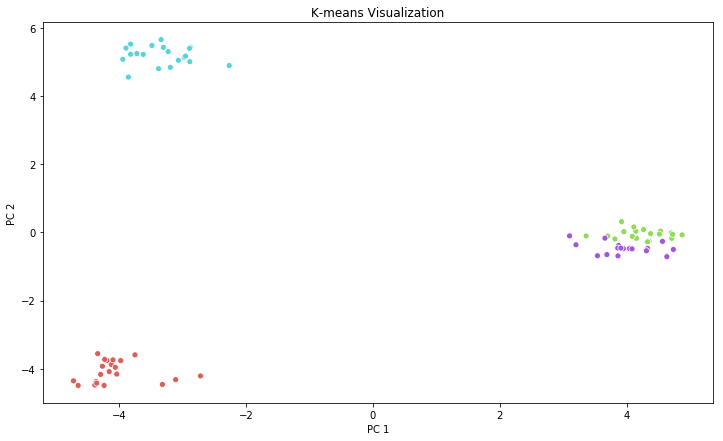

In [27]:
import seaborn as sns

# Plot k-means results with cluster assignments
plt.figure(figsize=(12,7))

ax = sns.scatterplot(
    x="pc_1",
    y="pc_2",
    data=df_pca_clusters,
    hue="cluster_id",
    legend=False,
    palette=sns.color_palette("hls", num_clusters)
)

ax.set(xlabel="PC 1", ylabel="PC 2", title="K-means Visualization");

## Plot Variable Distribution by Cluster

The below code loops through each categorical variable and plots the distribution of each variable by cluster, followed by doing the same for numerical variables. 

Taking the example of Cluster 5, we see that the majority of customers are homemakers or retired. Their primary pursuit is increasing net worth and they exhibit aggressive customer behaviour. All of the customers in this cluster are female, 55 or over, highly educated and urban living. Their annual income is mid-range while they are on the higher end for the amount they pay in fees.

In [38]:
prepped_data_pre['CLUSTERS'] = kmeans_mdl.labels_
# increment cluster numbers by 1 so we start at 1 instead of 0
prepped_data_pre['CLUSTERS'] = prepped_data_pre['CLUSTERS'] + 1



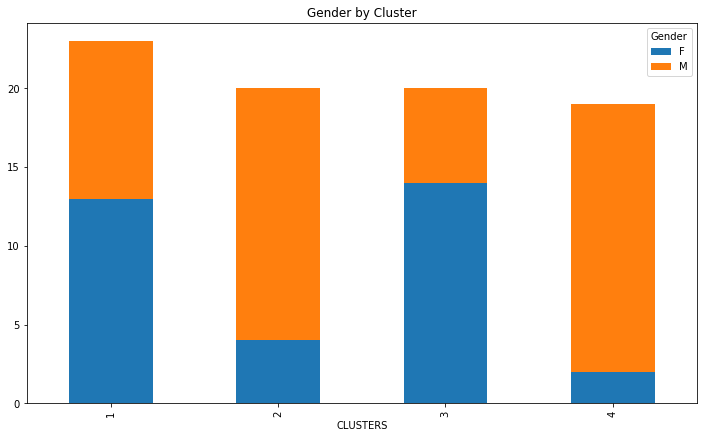

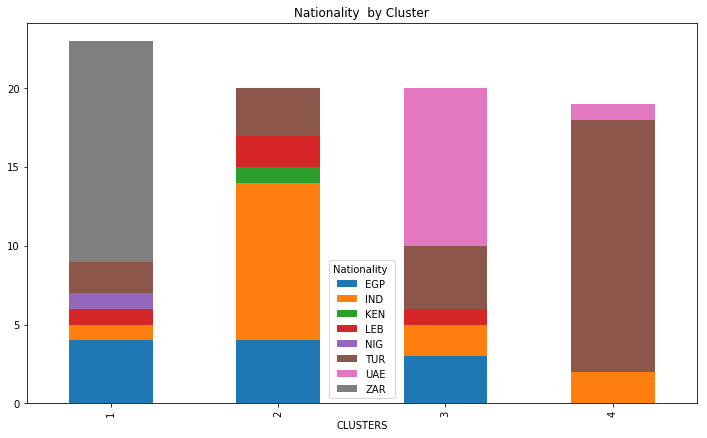

In [34]:
for var in categorical_cols:

    plot_categorical_vars(var, prepped_data_pre)

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


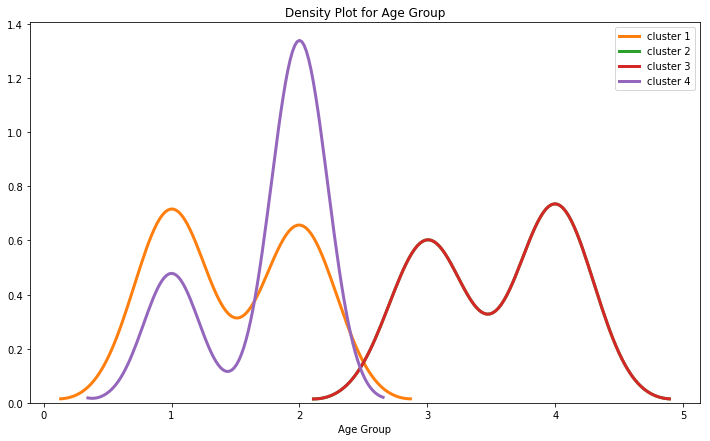

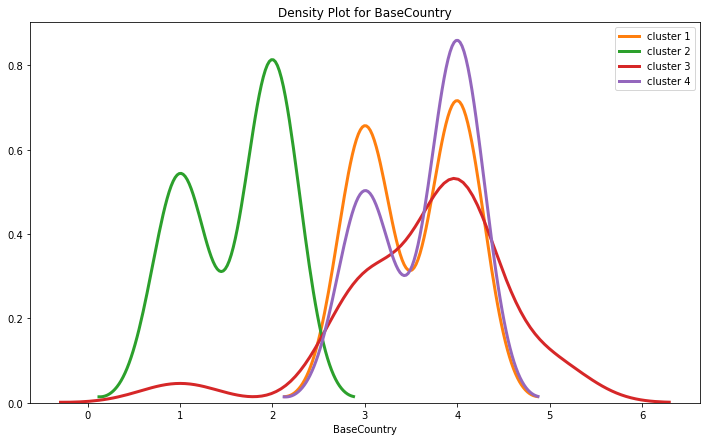

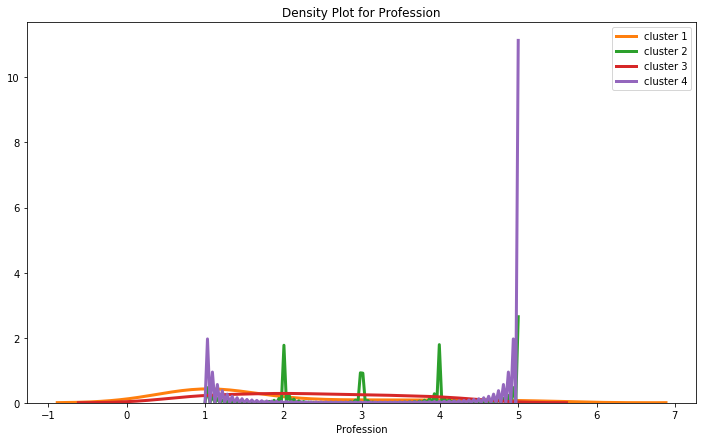

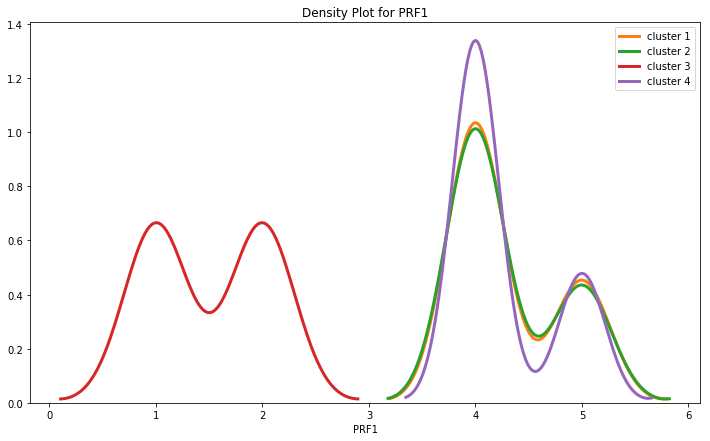

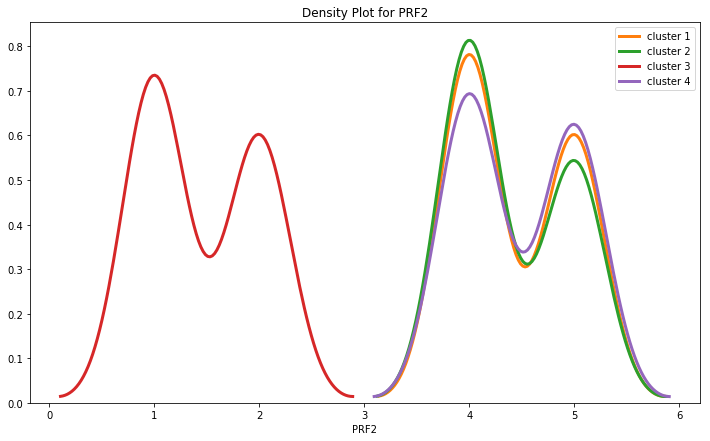

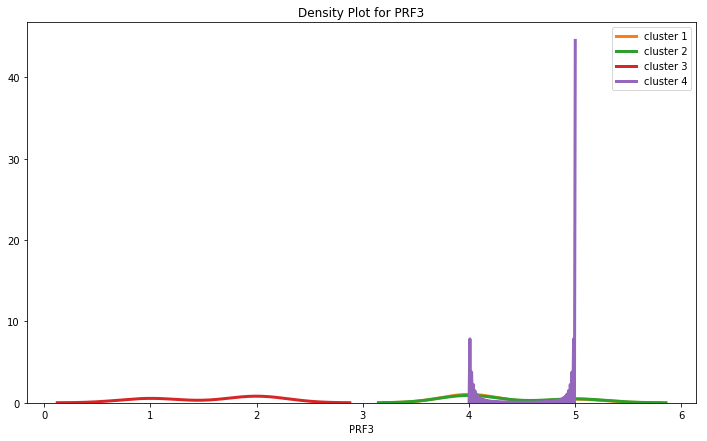

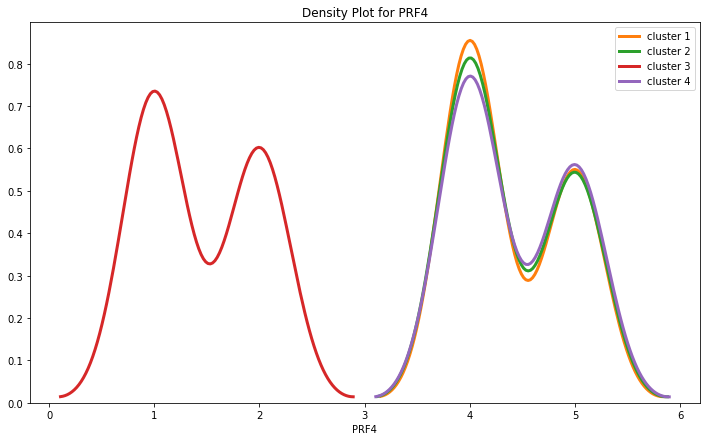

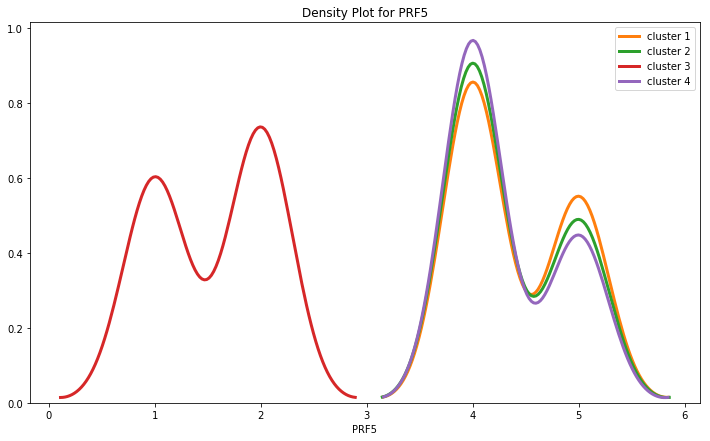

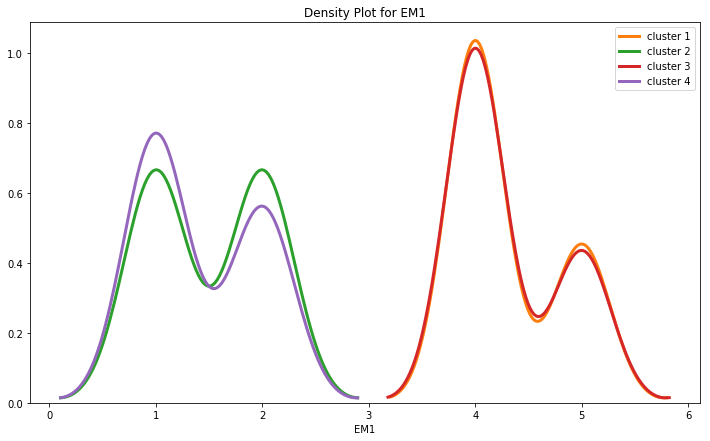

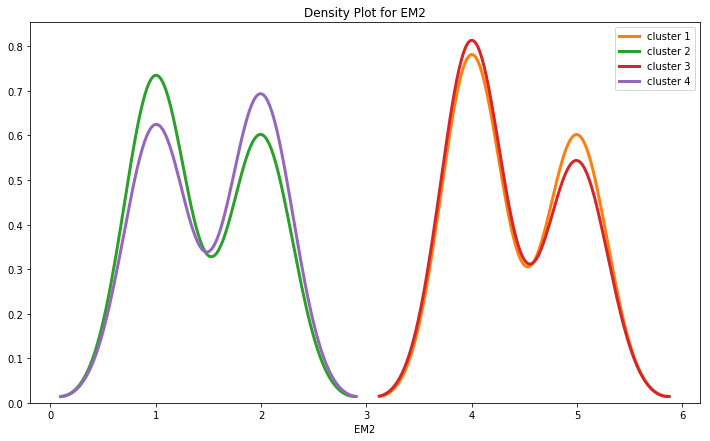

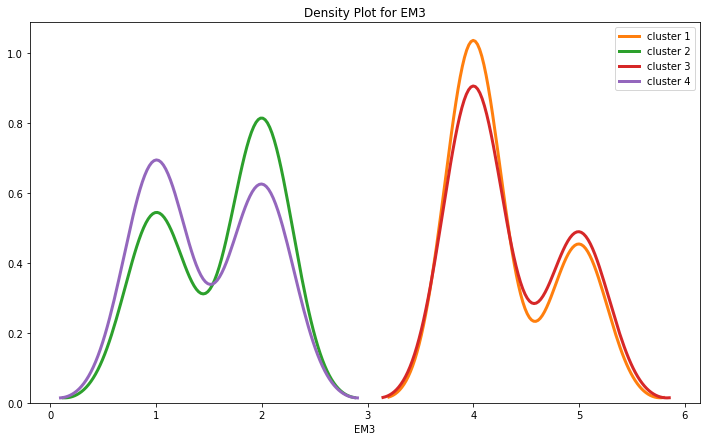

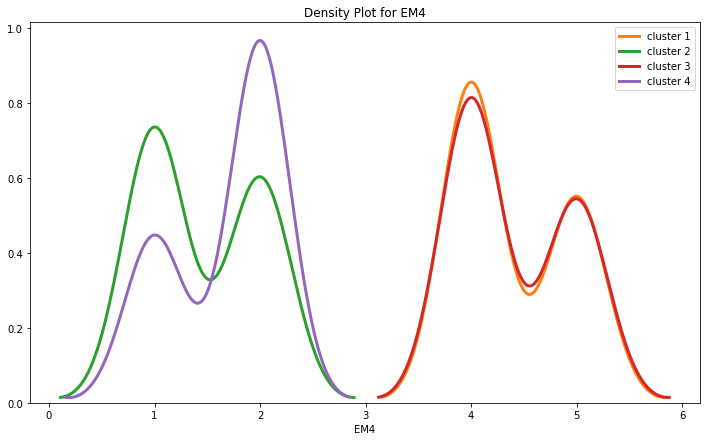

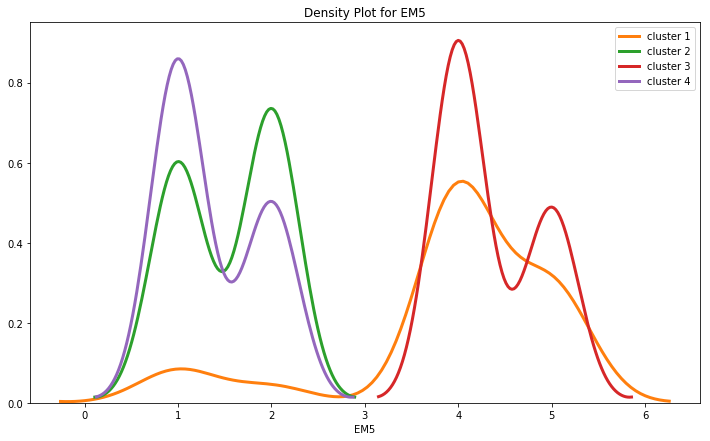

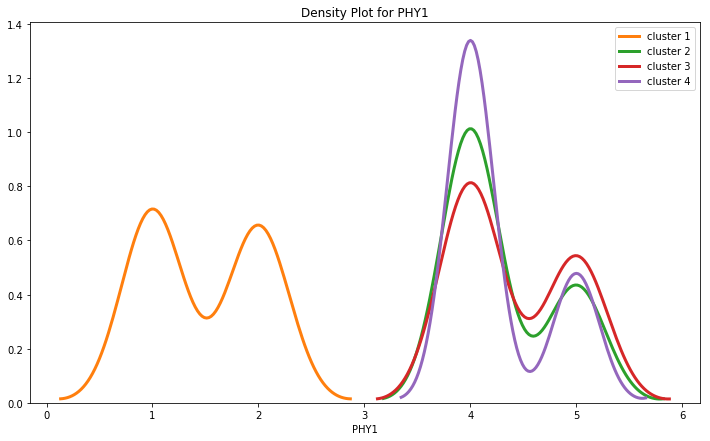

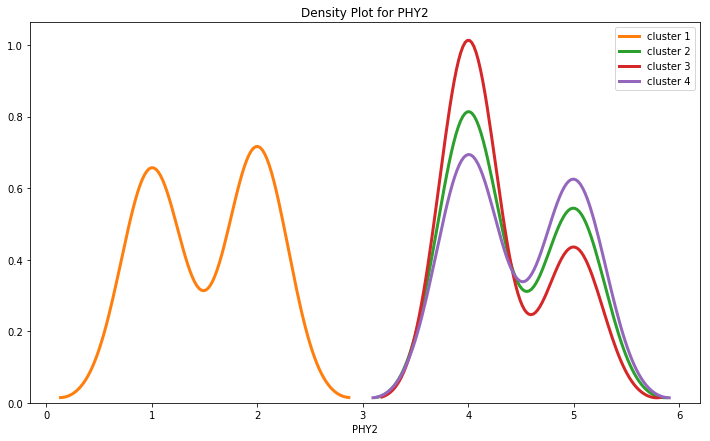

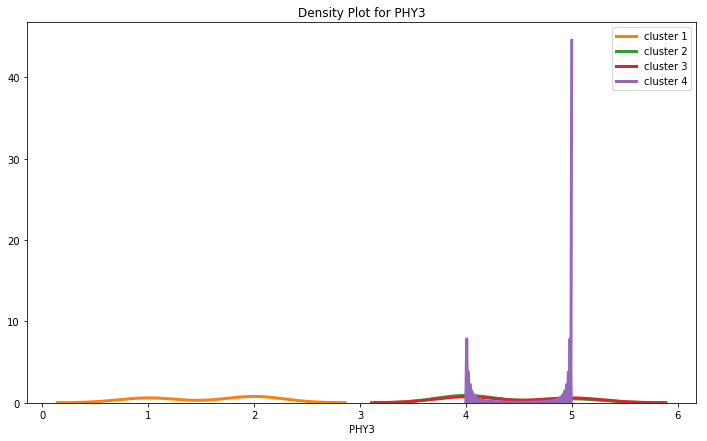

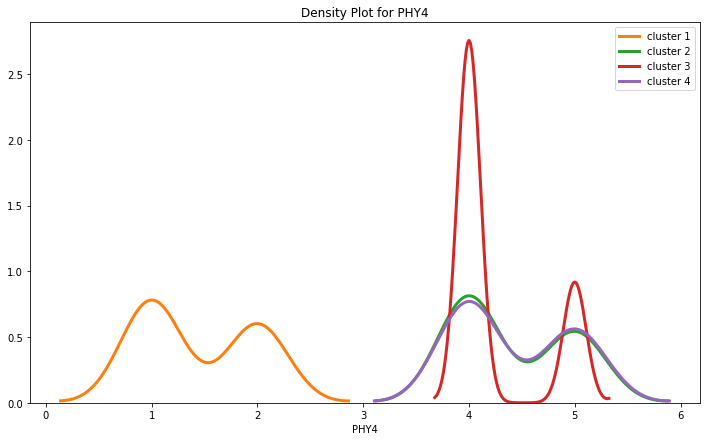

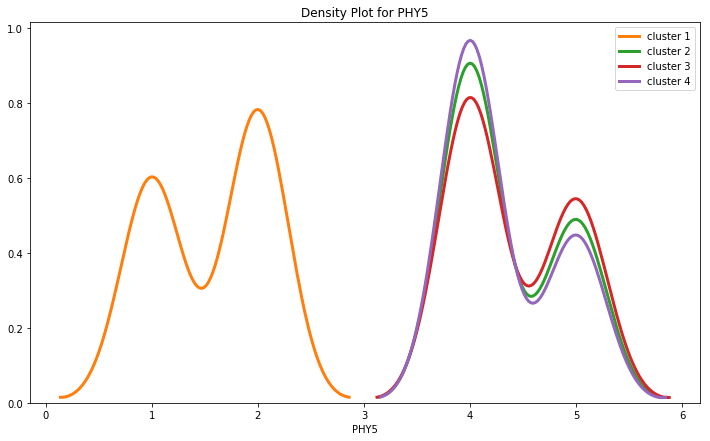

In [39]:
for col in numeric_cols:
    plot_numeric_vars(col, prepped_data_pre, num_clusters)